### 6.3.1 A temperature-forecasting problem

In [1]:
!mkdir jena_climate
!cd jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2021-06-30 12:52:03--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  15.7MB/s    in 0.8s    

2021-06-30 12:52:04 (15.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os

data_dir = '/content/jena_climate'    #it makes an empty folder with jena_climate name
fname = os.path.join(data_dir, '/content/jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

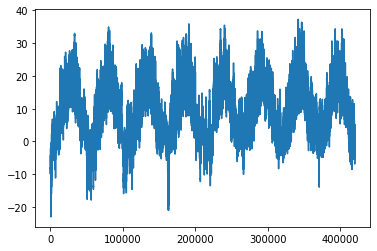

In [4]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

Plotting the first 10 days of the temperature timeseries

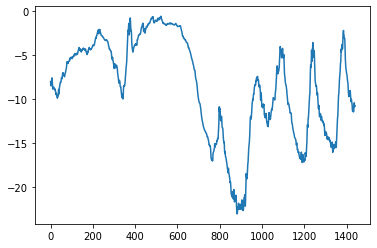

In [5]:
plt.plot(range(1440), temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
6*24*5

720

In [8]:
def generator(data, lookback, delay, min_index, max_index,  shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
          min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [10]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
evaluate_naive_method()

0.28969941979609765


In [11]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

 Training and evaluating a densely connected model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 918s 2s/step - loss: 1.3779 - val_loss: 0.7673
Epoch 2/20
500/500 [==============================] - 913s 2s/step - loss: 0.4690 - val_loss: 0.3334
Epoch 3/20
500/500 [==============================] - 917s 2s/step - loss: 0.3012 - val_loss: 0.3216
Epoch 4/20
500/500 [==============================] - 926s 2s/step - loss: 0.2736 - val_loss: 0.3154
Epoch 5/20
500/500 [==============================] - 914s 2s/step - loss: 0.2572 - val_loss: 0.3143
Epoch 6/20
500/500 [==============================] - 908s 2s/step - loss: 0.2444 - val_loss: 0.3299
Epoch 7/20
500/500 [==============================] - 929s 2s/step - loss: 0.2378 - val_loss: 0.3286
Epoch 8/20
500/500 [==============================] - 929s 2s/step - loss: 0.2308 - val_loss: 0.3423
Epoch 9/20
500/500 [==============================] - 909s 2s/step - loss: 0.2240 - val_loss: 0.3460
Epoch 10/20
500/500 [==============================] - 900s 2s/step - loss: 0.2208 - val_lo

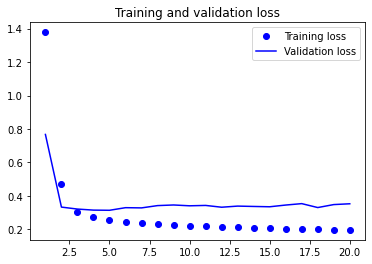

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

A first recurrent baseline
it should be the perfect fit for such sequence
data, precisely because it exploits the temporal ordering of data points, unlike the first
approach.


*   GRU (Gated Recurent Unit)
*   developed by Chung et al. in 2014.

cheaper to run (although they may not have as much representational power as
LSTM ). This trade-off between computational expensiveness and representational
power is seen everywhere in machine learning


 Training and evaluating a GRU-based model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=5,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 [==============================] - 5253s 1308s/step - loss: 0.6418 - val_loss: 0.3361
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.4064

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()